# Found methods
1) To control the robot in from pyrep, change the target node. And it would follow it.
<br>2) Perform regular checks using pyrep and update way_points regularly
<br>3) Create a function which steps one simulation and updates the waypoint via checking whether fish is near the waypoint


<br> The above methods are required for better performance


# This version info
<br> 1) Orientation check is added.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time
import math
import random
from IPython.display import clear_output
import sys

import heapq as hq #for priority que


import threading #for simulating and multipath program|ming


# initialise Vrep parameters
from pyrep import PyRep
pr = PyRep()
from pyrep.objects.object import Object
from pyrep.objects.joint import Joint
from pyrep.objects.shape import Shape
from pyrep import const

In [4]:
# state is np array (x,y,theta) 
# action is np array (dx,dy,dtheta)



def get_next_state_old(state1,action):
    
    state = np.copy(state1) # create the new state
    
    state[0] = state[0] + action[0]*math.cos(state[2]) - action[1]*math.sin(state[2])#get x
    state[1] = state[1] + action[0]*math.sin(state[2]) + action[1]*math.cos(state[2])#get y
    if(state[2]<0):
        state[2] = 2*math.pi+state[2] #if theta is negative. get the correct theta.changes. Please
    state[2] = (state[2] + action[2])%(2*math.pi) # get theta
    
    return state

def get_next_state(state1,action):
    
    state = np.copy(state1) # create the new state
    atm = np.identity(3,dtype = float)
    atm[0,0] = np.cos(action[2]); atm[0,1] = -np.sin(action[2]); atm[0,2] = action[0];
    atm[1,0] = np.sin(action[2]); atm[1,1] = np.cos(action[2]);  atm[1,2] = action[1];
    #print(atm)
    aitm =  np.linalg.inv(atm)
    
    tm = np.identity(3,dtype = float)
    tm[0,0] = np.cos(state[2]); tm[0,1] = -np.sin(state[2]); tm[0,2] = state[0];
    tm[1,0] = np.sin(state[2]); tm[1,1] =  np.cos(state[2]); tm[1,2] = state[1];
    #print(tm)
    new_tm = np.dot(tm,aitm) #get new transformation matrix
    #print(new_tm)
    state[0] = new_tm[0,2]
    state[1] = new_tm[1,2] #get the states
    
  
    state[2] = (state[2] - action[2])
   # print("2.5",state[2])
    if(state[2]<0):
        state[2] = 2*math.pi+state[2] #if theta is negative. get the correct theta. Again do the same thing
    #print("3",state[2])
    state[2]=state[2]%(2*math.pi) # get theta
   # print("4",state[2])
    #print(state[2])
    
    
    return state

def compute_cost(m1,m2): # can be used to compute to distance between two  vectors
    dm = m1-m2 # this creates a new array here
    return math.sqrt(dm[0]*dm[0]+dm[1]*dm[1])

def get_flow_index(orientation,flow_dir): # get the flow index with respect to robot
    # get the flow relative to robot
    rel_flow = np.zeros((2,),dtype=float)
    rel_flow[0] = flow_dir[0]*math.cos(orientation) + flow_dir[1]*math.sin(orientation)
    rel_flow[1] = -flow_dir[0]*math.sin(orientation) + flow_dir[1]*math.cos(orientation)
    # get the flow index
    fl = [1,1] # this [1,1] to get the index for [0,0] flow
    max_f = abs(max(rel_flow,key=abs)) #get the maximum abs
    if(max_f!=0): #if there are no double zeros
            fl[0] = round(rel_flow[0]/max_f) + 1 
            fl[1] = round(rel_flow[1]/max_f) + 1 
    return 3*fl[0] + fl[1] 

In [5]:
df=pd.read_csv('action_space.csv')# read the csv for state action pairs
df

,x,y,theta
0,1.0392,-0.6,-0.130
1,1.2000,0.0,0.240
2,1.0392,0.6,0.780
3,1.0392,-0.6,-0.630
4,1.2000,0.0,-0.130
5,1.0392,0.6,0.640
6,1.0392,-0.6,-0.860
7,1.2000,0.0,-0.490
8,1.0392,0.6,0.266
9,1.0392,-0.6,-0.580


#process the action space for d*lite for processing
r,c=df.shape
for i in range(r):
    x = df.iloc[i,0]
    y = df.iloc[i,1]
    th = df.iloc[i,2]
    s = np.sin(math.pi+th)
    c = np.cos(math.pi+th)
    T = np.identity(3,dtype=float)
    R = np.array(((c,-s),(s,c)))
    T[0:2,0:2]=R
    T[0,2]=x
    T[1,2]=y
    it = np.linalg.inv(T)
    df.iloc[i,0]=it[0,2]
    df.iloc[i,1]=it[1,2]
    df.iloc[i,2]=-th
    

In [6]:
df

,x,y,theta
0,1.0392,-0.6,-0.130
1,1.2000,0.0,0.240
2,1.0392,0.6,0.780
3,1.0392,-0.6,-0.630
4,1.2000,0.0,-0.130
5,1.0392,0.6,0.640
6,1.0392,-0.6,-0.860
7,1.2000,0.0,-0.490
8,1.0392,0.6,0.266
9,1.0392,-0.6,-0.580


In [7]:
actions = df.values # convert the csv to numpy array , sliced vectors are diminesio (3,null)

In [8]:
gmag = 1.2 # the spherical step size is 1.2
flow = [0,0]
class node:  # this class uses global variable and hence global vars must be initialised first before calling
    def __init__(self,parent,state):
        self.parent = parent #initially set to zero
        self.state = state  # store the states and parents
        self.g_cost = float('inf') #Set infinity  as per D*Lite
        self.rhs = float('inf')
        self.children = [0]*3 #set the three childrens although these are pointers
        
        #keyself = [key,u_index,object] which is stored in U
        # key = [min(g,rhs)+h;min(g,rhs)]
        self.keyself=0
        
        self.is_U=False #to find out whether it is in open list or not.
        
        #self.edcost_pc = float('inf') #edge cost currently infinity
        self.edcost_pc = 1.2# edge cost currently 1.2

    def __str__(self):
        return "state-> "+str(self.state[0])+", "+str(self.state[1])+", "+str(self.state[2]*180/math.pi)+", rhs-> "+str(self.rhs)+" gcost- "+str(self.g_cost)

        


In [9]:
class rectangle:
    def __init__(self,x,y,height,width):
        #x is the lowest point irrespective of the quadrant. Thus next corner x would be x + width. 
        self.x = x
        self.y = y
        self.height = height
        self.width = width
    def __str__(self):
        return str(self.x)+", "+str(self.y)+", "+str(self.width)+", "+str(self.height)
    

In [10]:
range_x = 75
range_th = 16

s_x = range_x/15 #cordinate multiplier for co-ordinates
s_th = range_th/(2*math.pi) #multipliers for grid indices for orientation discretised in range_th values

In [11]:
#get grid node. 
def grid_node(pose):
    global s_x,s_th,grid #refrer to global vars
    if(pose[0]>=15 or pose[1]>=15):
        return sys.exit('x and y values are above 15')
    return grid[int(s_x*pose[0])][int(s_x*pose[1])][int(s_th*pose[2])]

In [12]:
grid=[] #create a 3D array of node objects.
for i in range(range_x):
    x=[]
    for j in range(range_x):
        th=[]
        for k in range(range_th):
            gstate = np.array([i/s_x,j/s_x,k/s_th]) 
            th.append(node(0,gstate)) #add the node attributes #states are added here
        x.append(th)
    grid.append(x)        
           

In [13]:
#create children for grid nodes 
#pre_computation for faster end computation
flow = [0,0]
gu = 0
for i in range(range_x):
    for j in range(range_x):
        for k in range(range_th):
            
            cnode = grid[i][j][k]
            cc = []
            state = cnode.state
            f_index = get_flow_index(state[2],flow) # get the flow index from orientation and flow
            for m in range(3): #stupid rename it as m. dont use "i" everywhere. spent 3hrs debugging the silly mistake
                        action = actions[(3*f_index+m),:]  # get the action for respective floe
                        child_state = get_next_state(state,action) #get the next state for applied action
                        
                        if(child_state[0]>=15 or child_state[1]>=15 or child_state[0]<0 or child_state[1]<0):
                            cc.append(0) #append 0 to children, this keeps no of children same. 
                        else: 
                            child_node = grid_node(child_state) #get the associated node
                            cc.append(child_node)
     
            cnode.children = cc #set the children
                
                
                                
                  
           

In [14]:
def flush_grid():
    global grid #refere to the global
    for i in range(range_x):
        for j in range(range_x):
            for k in range(range_th):
                cnode = grid[i][j][k]
                cnode.parent = 0 #initially set to zero
                cnode.g_cost = float('inf') #Set infinity  as per D*Lite
                cnode.rhs = float('inf')
                #keyself = [key,u_index,object] which is stored in U
                # key = [min(g,rhs)+h;min(g,rhs)]
                cnode.keyself=0

                cnode.is_U=False #to find out whether it is in open list or not.

                #self.edcost_pc = float('inf') #edge cost currently infinity
                cnode.edcost_pc = 1.2# edge cost currently 1.2

                

In [15]:
#create the environment
# launch the coppeliasim
pr.launch('eel_for_conference.ttt', headless=False) 
pr.step()


In [16]:
sim = True
def dumrum():
    global sim
    while(sim):
        pr.step()
    

In [17]:
action_hull = []
#hull =  Object.get_object('hull')
action0 = Object.get_object('action0')
action1 = Object.get_object('action1')
action2 = Object.get_object('action2')



hull = Object.get_object('hull')

#action_hull.append(hull)
action_hull.append(action0)
action_hull.append(action1)
action_hull.append(action2)

action_hull.reverse()

#Goal
goal_ob = Object.get_object('Goal')


#eel links 
wpoint = Object.get_object('waypoint')



In [18]:
link = Object.get_object('link4')
links = [Object.get_object('link4'),Object.get_object('link3'),Object.get_object('link2'),Object.get_object('link1'),Object.get_object('link0')]


In [19]:
def eudis(p1,p2):
    pp = p1-p2
    return math.sqrt(np.sum(np.square(pp)))

In [20]:
#obstacle features
grid_size = 13
no_of_obstacles = 6
obs_dia = 2.3
obs_gap = 1.5

obs_count = no_of_obstacles-1
obs_points=[]
while(obs_count>0):
    #get a random point
    #obs=np.random.randint(grid_size,size=(3,))
    
    obs = np.zeros((3,),dtype=float)
    obs[1] = random.randint(1, grid_size)
    obs[2] = 0.5
    obs[0] = random.randint(1, grid_size)  
    
    s1=0
    if(len(obs_points)==0): #first time go through gere
           obs_points.append(obs)
    else:
        for opoint in obs_points:
            if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                s1=1
                break
            
        if(s1==0): #you put s1==1 thats why it was wroung
            obs_points.append(obs)
           
            obs_count-=1
           
    
    
           
       
    
obs_points  

[array([10. ,  5. ,  0.5]),
 array([ 2. , 11. ,  0.5]),
 array([1. , 6. , 0.5]),
 array([ 8. , 10. ,  0.5]),
 array([3. , 1. , 0.5]),
 array([13. , 12. ,  0.5])]

In [21]:
'''
#create the shapes
for opoint in obs_points:
    Shape.create(const.PrimitiveShape.SPHERE,[obs_dia,obs_dia,obs_dia],1.0,False, False,False,False,True, True, opoint,None,None)
print("done")
'''

'\n#create the shapes\nfor opoint in obs_points:\n    Shape.create(const.PrimitiveShape.SPHERE,[obs_dia,obs_dia,obs_dia],1.0,False, False,False,False,True, True, opoint,None,None)\nprint("done")\n'

In [22]:
#get the sphere objects
spheres = []
spheres.append(Object.get_object('Sphere'))
l = len(obs_points)-1
for i in range(l):
    spheres.append(Object.get_object('Sphere'+str(i)))
    print('Sphere'+str(i))
for s in spheres:
    print(s.get_position())

Sphere0
Sphere1
Sphere2
Sphere3
Sphere4
[7.37500191 4.04999971 0.5       ]
[ 5.6500001  10.35000038  0.5       ]
[9.02500057 7.67499971 0.5       ]
[11.9499979   5.95000029  0.5       ]
[4.  6.  0.5]
[ 1.42500043 10.97500038  0.5       ]


In [23]:
for sphere in spheres:
    sphere.set_collidable(True) #set all the spheres collidable



for action_path in action_hull:
    action_path.set_collidable(False) #initially set false. Then when required we only set one

hull.set_collidable(False) #we set this uncollidable
    

In [24]:
def get_rot_array(state):
    rot_array = np.identity(4,dtype=float)
    rot_array[0,0]=math.cos(state[2]); rot_array[0,1]=-math.sin(state[2]);
    rot_array[1,0]=math.sin(state[2]); rot_array[1,1]= math.cos(state[2]);
   
    rot_array[0,3]=state[0]
    rot_array[1,3]=state[1]
    rot_array[2,3]=0.5    #since its floating  in water
    return rot_array


In [25]:
def h_cost(m1,m2): # can be used to compute to distance between two  vectors
    dm = m1-m2 # this creates a new array here
    return math.sqrt(dm[0]**2+dm[1]**2)

In [26]:
def plot_points(xr,yr,x_obs,y_obs):
    plt.scatter(x_obs,y_obs,s=15,c='gray')
    plt.scatter(xr,yr,s=15,c='red')
    plt.show()
    

In [27]:
def calckey(node_state):
    global start_node,km
    minn = min(node_state.g_cost,node_state.rhs)
    return [minn+h_cost(start_node.state,node_state.state)+km,minn]   #stupid 

In [28]:
def prepare_goal(force_orientation):
    global U,u_index,goal_node,goal_or_nodes
    u_index=0
    if(force_orientation):
        #That means robot should reach in that specific orientation only. Dont forget to change to compare the states
        goal_node.rhs = 0 #set rhs =0 for goal node
        kself = [calckey(goal_node),u_index,goal_node]
        goal_node.keyself = kself #self reference d
        hq.heappush(U,kself) #add goal node and key in U list
        goal_node.is_U = True
        u_index+=1
    else:
        for gnode in goal_or_nodes:
            gnode.rhs=0
            kself = [calckey(gnode),u_index,gnode]
            hq.heappush(U,kself) #add goal node and key in U list
            gnode.keyself = kself #add the keyself also
            u_index+=1
            
            
            
        
        
    

In [29]:
#initialise
U=[]


gx = 8; gy=12; 

all_nodes = [] #damn I forgot to empty this during initialisation. All the mess for now
start_pose = np.array([1,1,0]) #the start location of
start_node = grid_node(start_pose)

km=0 #key modifier

goal_pose = np.array([gx,gy,math.pi/4])
goal_node = grid_node(goal_pose) #get the grid node from pose


goal_or_nodes = [] #define list of goal nodes to look as goal as indepent of orientation.
#stupid discretising angular space in 36 while grid space is max 16. lol
#goal_angles =  list(10*j for j in range(36)) #goal angle in degrees  #goal angle in degrees
goal_angles = list(30*j for j in range(11))
goal_angles.extend([45,135,225,315])
for goal_angle in goal_angles:
    goal_or_nodes.append(grid_node(np.array([gx,gy,math.pi/180*goal_angle]))) #store the goal nodes
    

prepare_goal(False)



xrr = []
yrr = []

xrr.append(goal_node.state[0])
yrr.append(goal_node.state[1])



spheres_pos=[]
spheres_vel=[]

#load the spheres
for sphere in spheres:
    spheres_pos.append(sphere.get_position())
    spheres_vel.append(sphere.get_velocity()[0])
    


In [30]:
def init(force_orientation):
    #refer to globals
    global U
    global xrr,yrr
    global u_index
    global goal_node
    global start_node
    global start_pose,all_nodes,km,spheres_pos,spheres_vel,xo,yo,gx,gy,goal_or_nodes, goal_pose, goal_node, goal_ob
    #initialise
    U=[]
    goal_ob.set_position([gx,gy,0.5]) #set position of goal in coppeliasim
    all_nodes = [] #damn I forgot to empty this during initialisation. All the mess for now
    start_pose = np.array([1,1,0]) #the start location of
    start_node = grid_node(start_pose)

    goal_pose = np.array([gx,gy,math.pi/4])
    goal_node = grid_node(goal_pose) #get the grid node from pose
    
    goal_or_nodes = []
    
    #stupid discretising angular space in 36 while grid space is max 16. lol
    #goal_angles =  list(10*j for j in range(36)) #goal angle in degrees  #goal angle in degrees
    goal_angles = list(30*j for j in range(11))
    goal_angles.extend([45,135,225,315])
    for goal_angle in goal_angles:
        goal_or_nodes.append(grid_node(np.array([gx,gy,math.pi/180*goal_angle]))) #store the goal nodes


    prepare_goal(force_orientation)

    spheres_pos = []
    spheres_vel = []
    

    xrr = []
    yrr = []
    xo=[];yo=[];
    xrr.append(goal_node.state[0])
    yrr.append(goal_node.state[1])
    
    #load the spheres
    for sphere in spheres:
        spheres_pos.append(sphere.get_position())
        spheres_vel.append(sphere.get_velocity()[0])



In [31]:
def set_obstacles():
    global spheres,gx,gy
    #obstacle features
    grid_size = 14
    no_of_obstacles = 6
    obs_dia = 2.3
    obs_gap = 1

    obs_count = no_of_obstacles-1
    obs_points=[]
    while(obs_count>0):
        #get a random point
        #obs=np.random.randint(grid_size,size=(3,))

        obs = np.zeros((3,),dtype=float)
        obs[1] = random.randint(3, grid_size)
        obs[2] = 0.5
        obs[0] = random.randint(3, grid_size)  

        s1=0
        if(len(obs_points)==0): #first time go through gere
               obs_points.append(obs)
        else:
            for opoint in obs_points:
                if(eudis(obs,opoint)<(obs_dia+obs_gap)): #check the inter distance of obstacles
                    s1=1
                    break
                    
            
                

            if(s1==0): #you put s1==1 thats why it was wroung
                obs_points.append(obs)
                print(obs)
                obs_count-=1



    for i in range(len(spheres)):
        spheres[i].set_position(obs_points[i])


    

In [32]:
def update_edge_costs():
    for i in range(74):
        for j in range(74):
            n = grid[i][j][12:15]
            #print(n[0].state)
            if(check_collision(n[0])):
                n[0].edcost_pc = float('inf')
                n[1].edcost_pc = float('inf')
                n[2].edcost_pc = float('inf')
                

In [33]:
def cmp_key(knode):
    return knode[0]

In [34]:
def update_vertex(current_node):  #worst case time complexity (N+log(N))
    global u_index,U,goal_node,nn
    nn = current_node
    parent = current_node.parent
    
    if(current_node!=goal_node):
        current_node.rhs = parent.rhs + current_node.edcost_pc  #rhs + edgecost
        
        #print('update rhs',current_node.rhs,current_node.g_cost)
    if(current_node.is_U):
        #rhs is now updated. U list contains keys,rhs with old values.
        #keyself is only updated on node push.
        
        #for reducing memory size. we can use old rhs,,old gvalue value. And re-create old key value
        # This is at the expense of time complexity or computing the keys
        #
        
        U.remove(current_node.keyself) #this removes the self instance from list (N)
        current_node.is_U = False
        hq.heapify(U) #heapify the U again due to deletion log(N)
        
    if(current_node.g_cost!=current_node.rhs):
        kself = [calckey(current_node),u_index,current_node]
        #print(U)
        hq.heappush(U,kself) #push the new val in U . log(N)
        current_node.is_U = True #its now in U
        current_node.keyself = kself #update the reference
        u_index+=1

In [35]:
def check_collision_old(state,action_no):

    p_matrix = get_rot_array(state)#get the transformation matrix
    p_mat = p_matrix[0:3,:]
    pmatt = p_mat.flatten()
    hull.set_matrix(pmatt.tolist()) #set the hull position to the parent position
    
    action_hull[action_no].set_collidable(True)
    
    is_colliding = action_hull[action_no].check_collision()
    action_hull[action_no].set_collidable(False)
    
    
    return  is_colliding#get apply the action convex hull for collision
    
    
    
    

In [36]:
def isInside(circle_x, circle_y, rad, x, y): 
      
    # Compare radius of circle 
    # with distance of its center 
    # from given point 
    
    if ((x - circle_x) **2 + 
        (y - circle_y) **2 <= rad **2): 
        return True; 
    else: 
        return False; 
    
        

In [43]:
eel_vel = 0.2
def check_collision(curr_node):
    global obs_dia,spheres_pos,eel_vel,spheres_vel
    hull_size = 1 #size of robot
    state = curr_node.state
    s1 = state[0]*1 #this is to avoid editing the object
    s2 = state[1]*1
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        #vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        s3=s1-vel[0]*t
        s4=s2-vel[1]*t #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size
        
        #if(state[0]<2.1 and state[0]>1.9 and state[1]<0.2 and state[1]>0):
       
        
        
        try:
            if(isInside(pos[0],pos[1],rad,s3,s4)):

                return True
        except:
            print(pos[0],pos[1],vel[0],vel[1])
            raise Exception("Check the above values") 
    return False
    

    
    
    
    
    

In [76]:
eel_vel = 0.2
def check_collision_w(curr_node):
    global obs_dia,eel_vel,spheres
    hull_size = 0.4 #size of robot
    state = curr_node.state
    s1 = state[0] #this is to avoid editing the object
    s2 = state[1]
    for sphere in spheres:
        pos = sphere.get_position()
        vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        s3=s1-vel[0][0]*t
        s4=s2-vel[0][1]*t #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size
        if(isInside(pos[0],pos[1],rad,s3,s4)):
            return True
    return False
    

    
    
    
    
    

In [64]:
eel_vel = 0.2
def check_collision_or(curr_node): #checks the collision for node with orientation also.
    global obs_dia,eel_vel,spheres
    hull_size_lateral = 0.072 #size of robot in lateral direction. squeashing to line.
    state = curr_node.state
     
    #obtain end points of line segment "a" and "b"
    dx = 0.325*math.cos(state[2]) 
    dy = 0.325*math.sin(state[2])
    sa1 = state[0]+dx 
    sa2 = state[1]+dy
    
    sb1 = state[0]-dx 
    sb2 = state[1]-dy
    
    for sphere in spheres:
        pos = sphere.get_position()
        vel = sphere.get_velocity()
        t = h_cost(start_node.state,state)/eel_vel #get the minimum time to reach
        #modify the state now
        dvx = vel[0][0]*t
        dvy = vel[0][1]*t
        sa3=sa1-dvx
        sa4=sa2-dvy #such that we can apply collision detection on the transformed point
        
        sb3=sb1-dvx
        sb4=sb2-dvy #such that we can apply collision detection on the transformed point
        rad = obs_dia/2+hull_size_lateral
        if(isInside(pos[0],pos[1],rad,sa3,sa4) or isInside(pos[0],pos[1],rad,sb3,sb4)):
            return True
    return False
    

    
    
    
    
    

In [1]:
def goal_condition(curr_node):
    #see its not checking the consistency hence a wrong direction is evaluated. Thus more replanning.
    curr_state = curr_node.state
    
    if(eudis(curr_state[0:2],start_pose[0:2])<0.6 and (abs(curr_state[2]-start_pose[2])<0.7)):
        return True and not check_collision(curr_node)
    else:
        return False
    '''if(curr_node==start_node):
        return True
    else:
        return False
    '''

In [47]:
#generate_children
xo=[]
yo=[]
xx=[]
yy=[]
def get_children(current_node):
    
    global error,xo,yo
    
    state = current_node.state #get the pose of the robot
    
    
    children = [] #possible childrens
    cc = current_node.children #get all the children children


    for i in range(3):
         
        if(len(cc)!=3):
            print(current_node)
            print(len(cc))
            print(current_node.state)
            print(cc)
            error = current_node
        if(cc[i]==0):
            #its a null node. It was outside the grid. We skip it
            continue   
            
        child_node = cc[i]  
        if(child_node.edcost_pc == float('inf') ):  
            #skip the colliding one. Don't add it.
            continue  #maybe don't add this dumbass. aaah just check for now.
            #print('is colliding')
            
        #print(child_node.parent)
        if(child_node.parent==0): #reaching the node for the first time . Most important path of the algorithm
            child_node.parent = current_node
     
        else:
            if(child_node.rhs>(current_node.rhs+child_node.edcost_pc) and child_node.parent!=current_node): #if node is already present
                #check if it can become the child
                child_node.parent = current_node
                #child_node.edcost_pc = 1.2 # also this. no more setting this up. I think it should be removed.
                

        
        
        children.append(child_node)
        

    return children#return the possible childrens

In [48]:
flow = [0,0]
gu = 0
error = 0
def compute_shortest_path(): #version 2 . Worst time complextiy is 3(N+log(N))
    
    
    mh=1000000
    i=1
    global gu,U,u_index
    #while(U[0][0]<calckey(start_node) or start_node.rhs!=start_node.g_cost):
    while(len(U)!=0):
        
        #print("U here ------------------------------------------------------------------------------------------------------")
        #print("U here ------------------------------------------------------------------------------------------------------")
        
        #print_u()

        i+=1
        if(i%10000==0):
            return [False,i] #return failure
        #print("U list below")
        #for uu in U:
        #    print(uu[2])
            
        u = hq.heappop(U) #get the top element of priority quee
        u[2].is_U = False
        
        
        gu = u
        #print("popping ====================================================================================================")
        #print("poped ",u[2])
        
        
        
        #clear_output(wait=True)
        
        manhattan  = np.sum(np.abs(u[2].state[0:2]))-1
        #print(manhattan)
        if(mh>manhattan or i<10):
            #print(i,u[2].state)
            mh = manhattan
            
            #continue #wtf is this  :< this wasted my 5 days in debugging. Stupid start debugging from top not bottom.                    
        
        k_new = calckey(u[2])
        if(u[0]<k_new):
            #print(u,"u[0]<knew skipping")
            #note u[0] is old key, u[2] is the pointer to the node object
            #print(u[2].state)
            kself = [k_new,u_index,u[2]]
            hq.heappush(U,kself) # log(N)
            u[2].keyself = kself #update the keyself also.
            u[2].is_U = True #again you are inserting it na
            u_index+=1
        
        
        elif(u[2].g_cost>u[2].rhs):
            #print(u,"u[2].gost>u[2].rhs skipping")
            u[2].g_cost = u[2].rhs
            #generate children here. And set their parent as u[1]
            childs = get_children(u[2])
            #print("poped children")
            for child in childs:
                #print(child)
                update_vertex(child) #update the vertex of its children 3(N+log(N)) , this updates its rhs value.

        else:
            u[2].g_cost = float('inf') #its over consistent
            #print("poping children for inconsistency")
            if(u[2].parent==0):
                continue
            update_vertex(u[2]) #update the parent also.
            childs = get_children(u[2])
            for child in childs:
                update_vertex(child) #update the vertex of its children 3(N+log(N))
                
        if(goal_condition(u[2]) and u[2].rhs!=float('inf')): #u[2].rhs! = float('inf') checks whether the u[2] recent update is there or not.
    
            return [True,i] #success  
        
    return [False, i]      
        
            

In [49]:
def plot_graph():
    global gu

    global xrr,yrr,spheres_pos,spheres_vel,xo,yo,xw,yw,xx,yy,rec,pcount,start_pose,tx,ty,ipx,ipy

    fig = plt.figure()
    axes = fig.add_subplot(111)
    #draw obstacles
    
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
    
    #print("rectangle is ",rec)
    #rect = patches.Rectangle((rec.x, rec.y), rec.width, rec.height, linewidth=1, edgecolor='r', facecolor='none') 
    #axes.add_patch(rect) #draw the concerened area

    #plot the waypoint path   
    axes.plot(xx,yy)
    #plot cone
    #axes.plot(tx,ty)
    
    #print("in plot",xo)
    axes.scatter([start_pose[0]],[start_pose[1]],100,'yellow',label= 'start')
    axes.scatter(xw,yw,50,'red',label='way-point_collision') #plot waypoint collision
    axes.scatter([goal_pose[0]],[goal_pose[1]],100,'green')
    axes.scatter(xx,yy,30,'green',label='way-points')
    axes.scatter(xo,yo,0.5,'blue',label='colliding')
    
    axes.scatter(ipx,ipy,0.5,'orange',label='scan')
    
    axes.set_xlim([-2,15])
    axes.set_ylim([-2,15])
    plt.savefig(str(pcount))
    pcount+=1
    plt.show()
    

In [50]:
def plot_obs():
    global xrr,yrr,spheres_pos,spheres_vel,xo,yo,xw,yw
    axes = plt.gca()
       #draw obstacles
    for pos,vel in zip(spheres_pos,spheres_vel):
        #pos = sphere.get_position()
        circle = plt.Circle((pos[0], pos[1]), obs_dia/2, color='gray')
        #axes.add_patch(circle)
        #vel = sphere.get_velocity()
        axes.arrow(pos[0], pos[1],vel[0]*10,vel[1]*10, head_width=0.5, head_length=0.3, fc='k', ec='k')
        plt.plot(xx,yy)
    #plt.scatter(xrr,yrr,5,'red')
    plt.scatter(xo,yo,1,'tan')
    plt.scatter(xw,yw,50,'red') #plot waypoint collision
    plt.scatter([goal_pose[0]],[goal_pose[1]],100,'green')
    axes.set_xlim([-2,15])
    axes.set_ylim([-2,15])
    plt.savefig('Obs_1')
    plt.show()

In [51]:
def get_waypoints(curr_node):
    global xx,yy
    w_nodes = [] #to store waypoint node pointers
    w_nodes.append(curr_node)
    xx = []
    yy = []

    while(curr_node.parent!=0):
        curr_node= curr_node.parent
        w_nodes.append(curr_node) #add the current node to the list
        xx.append(curr_node.state[0])
        yy.append(curr_node.state[1])
    return w_nodes #return the new way_nodes list
    

In [52]:
def update_obmap():
    global spheres,spheres_pos,spheres_vel
    spheres_pos=[]
    spheres_vel=[]
    #load the spheres. This stores an image of the obstacles and lets the algorithm complete
    for sphere in spheres:
        spheres_pos.append(sphere.get_position())
        vel = sphere.get_velocity()
        spheres_vel.append(vel[0])
        
    

In [53]:
def get_robot_state():
    pos = [0,0,0]

    for rlink in links:
        pos[0]+=rlink.get_position()[0]
        pos[1]+=rlink.get_position()[1]
        o = rlink.get_orientation()[2]
        if(o<0):
            o += 2*math.pi
        pos[2]+= o
    
    pos[0]=pos[0]/5;pos[1]=pos[1]/5;pos[2]=pos[2]/5;
    
    return pos
    

In [54]:
def inside_rec(rect,pos):
    if(pos[0]>=rect.x and pos[1]>=rect.y and pos[0]<=(rect.x+rect.width) and pos[1]<=(rect.y+rect.height)):
        return True
    else:
        return False
    
    

In [55]:
rec = rectangle(0,0,0,0) #define a rectangle
def update_map():
    global all_nodes,s_x,s_th,start_pose,xo,yo,rec,win
    c=0
    #win is the halflength of the window
    #create a square 
    cl = int(max(start_pose[0]-win,0)*s_x) #column left   column is axis
    cr = int(min(start_pose[0]+win,13)*s_x) #column right
    ru = int(min(start_pose[1]+win,13)*s_x)
    rd = int(max(start_pose[1]-win,0)*s_x) #row down
    
    #print("in update map pose is ",start_pose)

    
    
    xo = []; yo = [];
    should_update  = False
    for i in range(cl,cr):
        for j in range(rd,ru):
            nd_c = grid[i][j][:] #get the nodes --> this is wrong, this is not action space
            is_colliding = check_collision_w(nd_c[0]) #just check collision of only one, no need to check all
            # above line would change for different function.
            
            
            for nd in nd_c: #complexity N(Nu+log(Nu))
                
                
                
                
                parent = nd.parent
                should_update = parent !=0 #is true if different
              
                
                state = nd.state
                edge_cost = nd.edcost_pc #get the edge cost

                #check the collision
                #is_colliding = check_collision(nd)

                if(edge_cost == float('inf')):
                    if(not is_colliding):
                        nd.edcost_pc = 1.2 #update the edge cost
                        if(should_update):
                            update_vertex(nd) #update the vertex
                    else: #else its already colliding
                        xo.append(state[0])
                        yo.append(state[1])
                        
                else:
                    if(is_colliding):
                        nd.edcost_pc = float('inf') #update the edge cost
                        if(should_update):
                            update_vertex(nd) #update the vertex
                        xo.append(state[0])
                        yo.append(state[1])
            c+=1  
    #print("nodes in rec x3 ",c)

In [56]:
class line:
    def __init__(self,p1,p2): #p1 is [y1,x1] p2 is [y2,x2]
        self.xp = p1[1] 
        self.yp = p1[0]
        self.m = 0
        dx = p2[1]-p1[1]
        dy = p2[0] - p1[0]
        if(dx==0):
            self.m = float('inf')
        else:
            self.m = dy/dx
    def __repr__(self):
        return "x->"+str(self.xp)+"y-> "+str(self.yp)+" m->"+str(self.m) 

In [73]:
cone_rad=5
tx = []
ty = []

scanx=[]
scany=[]

ipx = []
ipy = []
def update_map_tri():
    global all_nodes,s_x,s_th,start_pose,xo,yo,rec,cone_rad,tx,ty,scanx,scany,ipx,ipy,cone_ang
    
         
    xo = []; yo = []; #make obs empty
    should_update  = False
    c=0
        
    rad = cone_rad 
    half_cone = cone_ang*math.pi/180
    #orient = start_pose[2] + 60*math.pi/180 #delete 60
    orient = start_pose[2]
    rob = [start_pose[0],start_pose[1]]
    tx = []; ty = []
    #get traingle points
    tx = [rob[0],rob[0]+rad*math.cos(orient+half_cone),rob[0]+rad*math.cos(orient-half_cone)]
    ty = [rob[1],rob[1]+rad*math.sin(orient+half_cone),rob[1]+rad*math.sin(orient-half_cone)]
    #print(tx,ty)
    points = []
    for i in range(3):
        points.append([ty[i],tx[i]])
    points.sort()
    # get the y range now..........
    y_l = min(max(int(s_x*points[0][0]),0),range_x) #lower indixes
    y_u = min(max(int(s_x*points[2][0]),0),range_x)  #upper
    x_low = points[0][1] #store the xpos for bottom most _point

    #get the lines now for three points
    lines = [line(points[0],points[1]), line(points[0],points[2]), line(points[1],points[2])]

    #given the y range get the x range for each y
    ipx = []; ipy = [];
    #print(points)
    #print(y_l,y_u)
    for y_index in range(y_l,y_u):
        #search for intersection
        y = y_index/s_x #get the concerned y pos
        intr = [] #define an empty list for storing intersections
        #print("hi")
        for li in range(3):
            x = lines[li].xp + (y-lines[li].yp)/(lines[li].m+0.00000001) #get the intersection

            ind_x = min(max(int(s_x*x),0),range_x) #convert to ind_x
            intr.append([abs(x-x_low),ind_x,x])

        intr.sort() #sort based on key index 0
        #x intercepts are intr
        ipy.append(y); ipx.append(intr[0][2])   
        ipy.append(y); ipx.append(intr[1][2])
        
        range_tri = [intr[0][1],intr[1][1]]
        range_tri.sort()
        
        #print(range_tri)
        
        for x_index in range(range_tri[0],range_tri[1]):
            nd_c = grid[x_index][y_index][:] #get the nodes for same x and y--> this is wrong, this is not action space
            
            #do a basic check
            is_colliding = check_collision_w(nd_c[0]) #just check collision of only one, no need to check all
          
            if(not is_colliding): #If not colliding that means it wont colliding for orientation check also.
                for nd in nd_c: #complexity N(Nu+log(Nu))
                    parent = nd.parent
                    should_update = parent !=0 #is true if different  
                    state = nd.state
                    edge_cost = nd.edcost_pc #get the edge cost

                    if(edge_cost == float('inf')):
                        nd.edcost_pc = 1.2 #update the edge cost
                        if(should_update):
                            update_vertex(nd) #update the vertex
                            
       
                            
            else: 
                #that means its colliding we need to do further check
                #is_colliding = check_collision_or(nd)
                for nd in nd_c: #complexity N(Nu+log(Nu))
                    #is_colliding = check_collision_or(nd) #do orinetation collision check for all node
                    parent = nd.parent
                    should_update = parent !=0 #is true if different  
                    state = nd.state
                    edge_cost = nd.edcost_pc #get the edge cost

                    if(edge_cost == float('inf')):
                        if(not is_colliding):
                            nd.edcost_pc = 1.2 #update the edge cost
                            if(should_update):
                                update_vertex(nd) #update the vertex
                        else: #else its already colliding
                            xo.append(state[0])
                            yo.append(state[1])       
                    else:
                        if(is_colliding):
                            nd.edcost_pc = float('inf') #update the edge cost
                            if(should_update):
                                update_vertex(nd) #update the vertex
                            xo.append(state[0])
                            yo.append(state[1])
                


In [71]:
c=0
xw = []
yw = []#waypoint collision
last_state = [0,0,0]
rexp = [];
rtime=[];
stime=[];
def run_robot():
    
    #set the waypoint
    global way_nodes,start_node,start_pose,c,km,xw,yw,last_state,rexp,rtime,rec,stime
    #way_nodes = get_waypoints(gu[2])
    rexp = [];
    rtime=[];
    stime=[];
    replans=0;

    i=0
    l=len(way_nodes)
    #print("num in run_robot",l)
    
    point = way_nodes[i].state
    wpoint.set_position([point[0],point[1],0.5])
    toggle = True
    hit = False #check whether the robot path is hitting 

    

    
    l1 = min(i+int(win/1.2),l-1)
    
    while(i<l):
        #pr.step()
        #calculate whether robot is reached the waypoint
        dp = link.get_position(wpoint)
        dis = math.sqrt(dp[0]**2 + dp[1]**2)
        
        l1 = min(i+4,l-1)
        if(dis>0.2):
    

            #implement collision checks
            for windex in range(i+1,l1):
                #print("checking",way_node.state)
                
                #print("checking")
                if(check_collision_w(way_nodes[windex])): #check using real time position, real time velocity
                    xw.append(way_nodes[windex].state[0])
                    yw.append(way_nodes[windex].state[1])
                    print("collision detected =============================================================")
                    print(way_nodes[windex].state)
                    '''
                    print("nodes below")
                    for ww in way_nodes:
                        print(ww.state)
                    '''
                    
                    print("stripped_way_nodes")
                    for ww in way_nodes[i+1:l1]:
                        print(ww.state)
                        
                    
                    
                    
                    #scan the graph for changes
                    start = time.time()
                    update_obmap() #update obstacle map
                    update_map_tri()
                    end = time.time()
                    print("scanning time ms",(end-start)*1000)
                    stime.append((end-start)*1000)
                    plot_graph()
                    xw = []
                    yw = [] 
                    
                    km+=h_cost(start_pose,last_state) #increase the key modifier // wrong its heuristic(slast plus current)
                    last_state = start_pose.copy()
                    #run compute cost

                    #print("start position was ",start_pose)
                    print("replanning ============================================================================")
                    start = time.time()
                    result = compute_shortest_path()
                    end = time.time()
                    if(not result[0]): #complextity(3(Nu+log(Nu))) per loop
                        print("Failure")
                        break
                    else:
                        print("Expanded nodes ",result[1], "Replan time ms",((end-start)*1000))
                        rexp.append(result[1])
                        rtime.append(int((end-start)*1000))

                    

                    #get the list of new way points

                    way_nodes = get_waypoints(gu[2])
                    
                    plot_graph()
                    

                    #set i =0  and l = len(way_nodes)

                    i=0
                    l = len(way_nodes)

                        
                        
                        
        
        if(dis<0.2):
            print("Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
            i+=1
            if(i==l):
                break
            point = way_nodes[i].state
            wpoint.set_position([point[0],point[1],0.5]) #update the waypoint
            #update the start node
            
            start_node = way_nodes[i]  #change it to grid node for velocity obstacles.
            start_pose = way_nodes[i].state
            
    
        
        
        
    print("no of replans ",replans)   
    print("renodes",rexp)
    print("retime",rtime)
    print("scanning times",stime)
    rr = np.array(rexp)
    
    print("mean nodes",np.mean(rr))
    print("mean replanning time",np.mean(rtime))
    print("mean scannning time",np.mean(stime))
    

In [40]:
sim=False
sim=True
t1 = threading.Thread(target=dumrum)
t1.daemon = True
t1.start()

In [53]:
#time.sleep(1)

In [59]:
gx = 12.0;gy=12.0;
#set_obstacles()

NameError: name 'pcount' is not defined

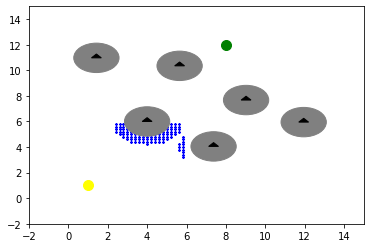

In [55]:
win = 5
update_obmap()
update_map() #this updates  the edge_cost
plot_graph()

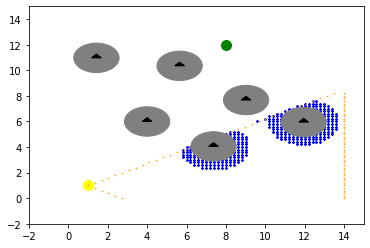

In [56]:
cone_rad = 15
pcount = 0
update_obmap()
update_map_tri()
plot_graph()

In [60]:
update_times = []
for twin in range(4,10):
    win = twin
    start = time.time()
    update_map()
    end = time.time()
    update_times.append((end-start)*1000)

print(update_times)
    

[176.83887481689453, 173.4766960144043, 226.8967628479004, 304.3677806854248, 352.1132469177246, 416.8739318847656]


In [62]:
update_times = []
cone_ang = 45
for twin in range(4,10):
    con_rad = twin
    start = time.time()
    update_map_tri()
    end = time.time()
    update_times.append((end-start)*1000)

print(update_times)

[68.71247291564941, 115.07296562194824, 61.472415924072266, 47.97792434692383, 49.263954162597656, 49.4692325592041]


In [88]:
init(False)

prep time 132.84659385681152
computing shortest distance
num way_points 12
[True, 18]
4.339694976806641
Expanded nodes  18


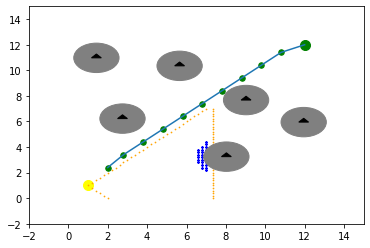

num way_points after graph 12
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
collision detected =============================================================
[7.8        8.4        0.78539816]
stripped_way_nodes
[5.8        6.4        0.78539816]
[6.8        7.4        0.78539816]
[7.8        8.4        0.78539816]
scanning time ms 194.67639923095703


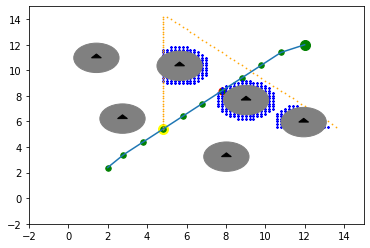

replanning ============================================================================
Expanded nodes  23 Replan time ms 2.968311309814453


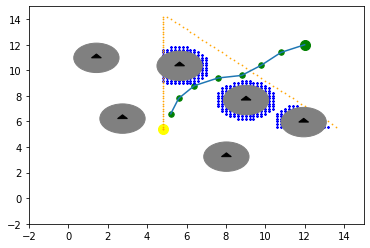

Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Waypoint changing |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
no of replans  0
renodes [23]
retime [2]
scanning times [194.67639923095703]
mean nodes 23.0
mean replanning time 2.0


In [78]:
#pr.start()
#set_obstacles() #set random position of obstacles.
#gx = 7;gy=7;
pr.stop()
pr.step()
pcount = 0
#win = 5
cone_rad = 9
cone_ang = 45
#pr.stop()
start = time.time()
flush_grid()
end = time.time()
print("prep time", (end-start)*1000)
init(False)
pr.start()
time.sleep(1)
update_obmap()
update_map_tri() #this updates  the edge_cost
#where is the spheres updates here.
start = time.time()
print("computing shortest distance")
result = compute_shortest_path()
way_nodes = get_waypoints(gu[2])
print("num way_points",len(way_nodes))
print(result)
end = time.time()
print((end-start)*1000)


if(not result[0]):
    print("failure")
    pr.stop()
else:
    print("Expanded nodes ",result[1])
    plot_graph()
    print("num way_points after graph",len(way_nodes))
#plt.savefig('Trajectory_1')

    run_robot()
    pr.stop()



1.0

In [130]:
sim=False

In [79]:
pr.shutdown()

In [ ]:
# Failure cause
1) First path made is useless and if obstacle changes it would be certain collision
<br> 2) Collision detection prediction seems to have problem. Yes. Replanning is faster. The way-point collision is always more.

# Solution
1) Edge costs are now 1.2. The initial plan is just a straight line.
<br> 2) The collision hull made larger for D*Lite* and smaller for way-points